In [93]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../GlacierLakeDetectionICESat2/GlacierLakeIS2ML/')

import shutil

from IS2ML_utils import *
from figscode import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#### to re-compile all data from the sources
# compile_IS2_comparison_data()

In [ ]:
fn_data = 'data/is2comp/comparison_melling_fricker.csv'
df_data = pd.read_csv(fn_data)

datadir = 'data/is2comp/h5/'
list_h5 = [datadir+f for f in os.listdir(datadir) if os.path.isfile(os.path.join(datadir, f)) & ('.h5' in f)]
list_h5.sort()
list_h5 = [x for x in list_h5 if 'lake_greenland_melling_' in x] + [x for x in list_h5 if 'lake_amery_fricker_' in x]
list_ids = [x.split('/')[-1].replace('.h5', '') for x in list_h5]
dffiles = pd.DataFrame({'id': list_ids, 'h5': list_h5})
dffiles['tiff'] = dffiles.id.apply(lambda x: 'data/is2comp/imagery/%s_ensemble_depth_estimates.tiff' % x)
dffiles

In [ ]:
df_data

In [ ]:
def get_xylims_aspect(ax, img, fig):
    axbbx = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    axis_aspect = axbbx.height / axbbx.width
    img_wid = img.bounds.right - img.bounds.left
    img_centerx = (img.bounds.right + img.bounds.left) / 2
    img_centery = (img.bounds.top + img.bounds.bottom) / 2
    img_hgt = img.bounds.top - img.bounds.bottom
    img_aspect = img_hgt / img_wid
    
    if axis_aspect > img_aspect:
        yl = (img.bounds.bottom, img.bounds.top)
        xl = (img_centerx - img_hgt/axis_aspect/2, img_centerx + img_hgt/axis_aspect/2)
    else:
        xl = (img.bounds.left, img.bounds.right)
        yl = (img_centery - img_wid*axis_aspect/2, img_centery + img_wid*axis_aspect/2)
    return xl, yl

In [ ]:
plt.close('all')

plt.rcParams.update({
    'font.size': 6,
    'text.usetex': True,
    'font.family': 'Optima',
    'text.latex.preamble': r"\usepackage{amsmath}"
})

labelsize = 7

colors = {
    'GrIS': '#D00C33', # Greenland flag
    'AIS': '#3A7DCE' # Antarctica, Graham Bartram Design
}

figwid = 8.5
fighgt = 10
fig = plt.figure(figsize=[figwid,fighgt])
nh = 4
gs = fig.add_gridspec(ncols=3, nrows=3*nh+1)
axbxs = []
for i in range(9):
    axbxs.append(fig.add_subplot(gs[nh*int(i/3):nh*int(i/3)+nh, i%3]))
    axbxs[-1].tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
    axbxs[-1].patch.set_facecolor('none')
    for spine in axbxs[-1].spines.values():
        spine.set_zorder(100)
        
axlegs = []
for i in range(3):
    axlegs.append(fig.add_subplot(gs[nh*3, i]))
    axlegs[-1].axis('off')
fig.tight_layout(pad=0.3, h_pad=1, w_pad=1)

def ith_letter(i):
        return chr(97 + i)
    
htop = 0.38
hbot = 0.45
pad_l = 0.125
pad_r = 0.03
pad_b = 0.065
pad_top = 0.01
pad_mid = pad_top * fighgt / figwid
pad_cbar = 0.01
pad_cbarlabel = 0.08
wid_cbar = 0.02
pad_vert = 0.015

plot_melling = ['manual', 'predicted_depth', 'surrf_2024', 'Green_z_lit', 'Red_z_lit']
plot_fricker = ['manual', 'predicted_depth', 'surrf_2024', 'RTE_Landsat8_red_pan', 'RTE_Sentinel2_red']
depth_keys = list(set(plot_melling + plot_fricker))

ref_idx = 1.336

cmap_img = cmc.lapaz_r

axs = []
for axbx in axbxs:
    axs_ = []
    wid_top = (1 - 2*pad_mid - pad_cbar - wid_cbar - pad_cbarlabel)/2
    axs_.append(axbx.inset_axes([pad_mid, 1-htop, wid_top, htop-pad_top])) # TCI full
    axs_.append(axbx.inset_axes([pad_mid*2+wid_top, 1-htop, wid_top, htop-pad_top], sharex=axs_[-1], sharey=axs_[-1])) # depth est full
    axs_.append(axbx.inset_axes([pad_mid*2+wid_top*2+pad_cbar, 1-htop, wid_cbar, htop-pad_top])) # colorbar 
    h_mid = 1 - (htop + hbot + pad_vert)
    axs_.append(axbx.inset_axes([pad_l, hbot, 1-(pad_l + pad_r), h_mid])) # along-track TCI
    axs_.append(axbx.inset_axes([pad_l, pad_b, 1-(pad_l + pad_r), hbot-pad_b], sharex=axs_[-1])) # along-track data
    for axx in axs_[:4]:
        axx.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
        for spine in axx.spines.values():
            spine.set_zorder(100)
    axs.append(axs_)

# for ilk, axset in enumerate([axs[i] for i in [0, 5]]):
for ilk, axset in enumerate(axs):
    
    files = dffiles.loc[ilk]
    id = files.id
    thisletter = ith_letter(ilk)

    source = id.split('_')[2]
    source_txt = 'Fricker et al., 2021' if source=='fricker' else 'Melling et al., 2024'
    location = 'Antarctic' if source=='fricker' else 'Greenland'
    axcolor = colors['AIS'] if source=='fricker' else colors['GrIS']

    # photon data and lake elevation / info
    lk = dictobj(read_melt_lake_h5(files.h5))
    df_phot = lk.photon_data.copy()
    hsurf = lk.surface_elevation
    date_time = lk.date_time
    afterpulse = df_phot.prob_afterpulse > np.random.uniform(0,1,len(df_phot))
    df_phot = df_phot[~afterpulse].copy().reset_index(drop=True)
    df_phot.loc[df_phot.h < hsurf, 'h'] = hsurf - (hsurf - df_phot.loc[df_phot.h < hsurf, 'h']) / ref_idx
    
    thisdf = df_data[df_data.id_lake==id].copy().sort_values(by='dist_along_track_m').reset_index(drop=True)
    gdf = gpd.GeoDataFrame(thisdf, geometry=gpd.points_from_xy(thisdf.lon, thisdf.lat), crs="EPSG:4326")
    img = rio.open(files.tiff)
    gdf = gdf.to_crs(img.crs)
    gdf[['x', 'y']] = gdf.geometry.get_coordinates()
    xoff = np.nanmin(thisdf['dist_along_track_m'])
    df_phot.xatc -= xoff
    gdf.dist_along_track_m -= xoff
    gdf['xatc'] = gdf.dist_along_track_m / 1000
    manual_nodepth = gdf.manual <= 0
    max_depth = gdf[depth_keys].max().max()
    xl_track = (0.0, np.nanmax(gdf.xatc))
    yl_track = (hsurf - 1.2 * max_depth, hsurf + 0.3 * max_depth)
    
    ax = axset[0]
    xl_img, yl_img = get_xylims_aspect(ax, img, fig)
    rgb = img.read([4,3,2])
    rgbmin = np.percentile(rgb, 0.2)
    rgbmax = np.percentile(rgb, 97) - rgbmin
    rgb = np.clip((rgb-rgbmin) / rgbmax, 0, 1) * 255
    rgb = rgb.astype(np.uint8)
    rioplot.show(rgb, ax=ax, transform=img.transform)
    ax.set_xlim(xl_img)
    ax.set_ylim(yl_img)

    ax = axset[1]
    depth = img.read(1)
    depthmin = 0
    depthmax = np.percentile(depth, 99.9)
    rioplot.show(depth, ax=ax, transform=img.transform, vmin=0, vmax=depthmax, cmap=cmap_img)
    depth0 = depth
    depth0[depth0 > 0.1] = np.nan
    nan_val = 0.1
    depth0[~np.isnan(depth0)] = nan_val
    rioplot.show(depth0, ax=ax, transform=img.transform, cmap=cmc.grayC, vmin=0, vmax=1)
    cax = axset[2]
    sm = plt.cm.ScalarMappable(cmap=cmap_img, norm=plt.Normalize(vmin=0, vmax=depthmax))
    sm._A = []
    cbar = plt.colorbar(sm, cax=cax, orientation='vertical')
    cax.axhline(0, lw=3, color=cmc.grayC(nan_val))
    labpad = 1 if depthmax < 10 else -2
    cbar.set_label('predicted depth (m)', labelpad=labpad, fontsize=labelsize)
    cbar.ax.tick_params(axis='y', direction='in', length=4, width=0.5, pad=2)

    dx = gdf.x.iloc[-1] - gdf.x.iloc[0]
    dy = gdf.y.iloc[-1] - gdf.y.iloc[0]
    gt_x = [gdf.x.iloc[0] + ix * dx for ix in range(-5, 5)]
    gt_y = [gdf.y.iloc[0] + iy * dy for iy in range(-5, 5)]
    xnan = gdf.x.copy()
    xnan[manual_nodepth] = np.nan
    for ax in axset[:2]:
        ax.plot(gt_x, gt_y, color=(0,1,0), lw=0.5)
        ax.plot(gdf.x, gdf.y, color='k', lw=0.7)
        ax.plot(xnan, gdf.y, color='r', lw=0.4)

    ax = axset[4]
    # remove all zeros except at the edge
    keys_fillna = list(set(depth_keys) - set(['surrf_2024', 'surrf_corr']))
    gdf[keys_fillna] = gdf[keys_fillna].fillna(0.0)
    for k in keys_fillna:
        to_remove = gdf[k].rolling(window=3, center=True, min_periods=1).mean() <= 0
        gdf.loc[to_remove, k] = np.nan
    gdf.loc[gdf.surrf_2024==0, 'surrf_2024'] = np.nan
    gdf.loc[gdf.surrf_corr==0, 'surrf_corr'] = np.nan
    ax.scatter(df_phot.xatc/1000, df_phot.h, s=6, color=[0.8]*3, alpha=0.5, edgecolors='none')
    lk_surf = gdf.xatc * 0 + hsurf
    lk_surf[manual_nodepth] = np.nan
    p_photons = ax.scatter([-999]*4, [-999]*4, s=4, color='gray', label='ATL03 photons')
    p_lksurf, = ax.plot(gdf.xatc, lk_surf, color='k', ls=':', lw=1.5, zorder=11, label='lake surface')
    p_manual, = ax.plot(gdf.xatc, hsurf-gdf.manual, color='k', label='manual depth', lw=1, zorder=10)
    p_predict, = ax.plot(gdf.xatc, hsurf-gdf.predicted_depth, color='r', label='predicted depth', lw=1, zorder=9)
    p_surrf, = ax.plot(gdf.xatc, hsurf-gdf.surrf_2024, color='C0', label='SuRRF', ls=':', lw=0.9, zorder=8)
    
    if source == 'fricker':
        # p_watta, = ax.plot(gdf.xatc, hsurf-gdf.watta, color='c', ls='--', label='Watta', lw=0.7)
        p_l8, = ax.plot(gdf.xatc, hsurf-gdf.RTE_Landsat8_red_pan, color='darkviolet', ls='--', label='RTE: Landsat 8 red/pan bands', lw=0.7)
        p_s2, = ax.plot(gdf.xatc, hsurf-gdf.RTE_Sentinel2_red, color='magenta', ls='--', label='RTE: Sentinel-2 red band', lw=0.7)

    if source == 'melling':
        # p_red, = ax.plot(gdf.xatc, hsurf-gdf.Z_red, color='deeppink', ls='--', label='RTE: Sentinel-2 red band', lw=0.7)
        # p_green, = ax.plot(gdf.xatc, hsurf-gdf.Z_green, color='forestgreen', ls='--', label='RTE: Sentinel-2 green band', lw=0.7)
        # p_dem, = ax.plot(gdf.xatc, hsurf-gdf.DEM_zeroed, color='y', ls='--', label='ArcticDEM', lw=0.7, zorder=9)
        p_red_lit, = ax.plot(gdf.xatc, hsurf-gdf.Red_z_lit, color='C1', ls='--', label='RTE: Sentinel-2 red band', lw=0.7)
        p_green_lit, = ax.plot(gdf.xatc, hsurf-gdf.Green_z_lit, color='forestgreen', ls='--', label='RTE: Sentinel-2 green band', lw=0.7)
    
    ax.set_xlim(xl_track)
    ax.set_ylim(yl_track)
    ylabs = [x for x in ax.get_yticks() if x % 1 == 0]
    ax.set_yticks(ylabs)
    ax.set_ylim(yl_track)
    ax.tick_params(axis='y', direction='in', pad=1, width=0.5)
    ax.tick_params(axis='x', direction='in', pad=2, width=0.5)
    ax.set_xlabel('along-track distance (km)', labelpad=0, fontsize=labelsize)
    ax.set_ylabel('elevation (m)', labelpad=2, fontsize=labelsize)

    # axis appearance
    for iax, ax in enumerate(axset):
        if iax != 4:
            ax.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
        for spine in ax.spines.values():
            spine.set_zorder(100)
            spine.set_linewidth(0.5)

# legends
hdls = [[p_photons, p_lksurf, p_manual, p_predict, p_surrf], [p_red_lit, p_green_lit], [p_l8, p_s2]]
tits = [r'\textbf{all panels}', r'\textbf{a-e): Greenland lakes (Melling et al., 2024)}', r'\textbf{f-i): Antarctic lakes (Fricker et al., 2021)}']
for i, ax in enumerate(axlegs):
    ncols = 2 if i==0 else 1
    leg = ax.legend(handles=hdls[i], ncols=ncols, loc='center', scatterpoints=4, fontsize=8, title=tits[i], title_fontproperties={'size': 8})
    leg._legend_box.align = "left"
    ax.add_artist(leg)
    legcolor = 'black'
    if i == 1:
        legcolor = colors['GrIS']
    elif i == 2:
        legcolor = colors['AIS']
    leg.get_frame().set_edgecolor(legcolor)  # Set the box edge color
    # legend.get_frame().set_linewidth(2)       # Set the width of the box edge
    # # Set the legend's title color
    leg.get_title().set_color(legcolor)

for iax, ax in enumerate(axbxs):
    id = dffiles.id.loc[iax]
    axcolor = colors['AIS'] if 'fricker' in id else colors['GrIS']
    for spine in ax.spines.values():
        spine.set_color(axcolor)
        spine.set_linewidth(1)
    ax.text(0.5, 0.5, '\\textbf{%s}' % ith_letter(iax), fontsize=20, transform=ax.transAxes, ha='center', va='center', zorder=101, color=axcolor)

# add the letters/numbers for panels
for ilk, axset in enumerate(axs):
    thisletter = ith_letter(ilk)
    id = dffiles.id.loc[ilk]
    axcolor = colors['AIS'] if 'fricker' in id else colors['GrIS']
    for iax, ax in enumerate([axset[i] for i in [0,1,3,4]]):
        ax.text(0.01, 0.99, '\\textbf{%s%i)}' % (thisletter, iax+1), color='black', ha='left', va='top', transform=ax.transAxes,
                fontsize=9, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle="Round, pad=0.2"))


In [ ]:
# ! cp data/is2comp/imagery/lake_greenland_melling_1_ensemble_depth_estimates.tiff data/is2comp/testing/

In [58]:
fnimg

'data/is2comp/testing/lake_greenland_melling_1_ensemble_depth_estimates.tiff'

In [124]:
fn_data = 'data/is2comp/comparison_melling_fricker.csv'
df_data = pd.read_csv(fn_data)

lakeid = 'lake_greenland_melling_1'
fnimg = 'data/is2comp/testing/%s_ensemble_depth_estimates.tiff' % lakeid
output_file = fnimg.replace('.tiff', '_rotated.tiff')
img = rio.open(fnimg)

thisdf = df_data[df_data.id_lake==lakeid].copy().sort_values(by='dist_along_track_m').reset_index(drop=True)
gdf = gpd.GeoDataFrame(thisdf, geometry=gpd.points_from_xy(thisdf.lon, thisdf.lat), crs="EPSG:4326")
gdf = gdf.to_crs(img.crs)
gdf[['x', 'y']] = gdf.geometry.get_coordinates()
xoff = np.nanmin(thisdf['dist_along_track_m'])
gdf.dist_along_track_m -= xoff
gdf['xatc'] = gdf.dist_along_track_m / 1000

lon0, lat0 = gdf.lon.iloc[0], gdf.lat.iloc[0]
lon1, lat1 = gdf.lon.iloc[-1], gdf.lat.iloc[-1]
loncenter = (lon0 + lon1) / 2
latcenter = (lat0 + lat1) / 2

crs_local = pyproj.CRS("+proj=stere +lat_0={0} +lon_0={1} +datum=WGS84 +units=m".format(latcenter, loncenter))
coordsloc = gdf.to_crs(crs_local).get_coordinates()
dy = coordsloc.y.iloc[-1] - coordsloc.y.iloc[0]
dx = coordsloc.x.iloc[-1] - coordsloc.x.iloc[0]
angle_deg = - 90 + math.degrees(math.atan2(dy, dx))
angle_deg = 45

# wkt_crs = '''
# PROJCS["Hotine_Oblique_Mercator_Azimuth_Center",
# GEOGCS["GCS_WGS_1984",
# DATUM["D_unknown",
# SPHEROID["WGS84",6378137,298.257223563]],
# PRIMEM["Greenwich",0],
# UNIT["Degree",0.017453292519943295]],
# PROJECTION["Hotine_Oblique_Mercator_Azimuth_Center"],
# PARAMETER["latitude_of_center",%s],
# PARAMETER["longitude_of_center",%s],
# PARAMETER["rectified_grid_angle",%s],
# PARAMETER["scale_factor",1],
# PARAMETER["false_easting",0],
# PARAMETER["false_northing",0],
# UNIT["m",1.0], 
# AUTHORITY["EPSG","8011112"]]''' % (lat0, lon0, angle_deg)

wkt_crs = '''PROJCS["Hotine_Oblique_Mercator_Azimuth_Center",
GEOGCS["GCS_WGS_1984",
DATUM["D_unknown",
SPHEROID["WGS84",6378137,298.257223563]],
PRIMEM["Greenwich",0],
UNIT["Degree",0.017453292519943295]],
PROJECTION["Hotine_Oblique_Mercator_Azimuth_Center"],
PARAMETER["latitude_of_center",%s],
PARAMETER["longitude_of_center",%s],
PARAMETER["rectified_grid_angle",%s],
PARAMETER["scale_factor",1],
PARAMETER["false_easting",0],
PARAMETER["false_northing",0],
UNIT["m",1.0]]''' % (lat0, lon0, angle_deg)

print(lat0, lon0, angle_deg)

67.09112394318659 -49.13499280196479 45


In [127]:
from osgeo import gdal

# Open the input file
ds = gdal.Open(fnimg)

# Calculate the new pixel size
geo_transform = ds.GetGeoTransform()
new_pixel_width = geo_transform[1] / 2
new_pixel_height = -geo_transform[5] / 2

# Reproject and upsample the image using GDAL
gdal.Warp(output_file, ds, dstSRS=wkt_crs, xRes=new_pixel_width, yRes=new_pixel_height, resampleAlg='bilinear')
# gdal.Warp(output_file, ds, dstSRS='EPSG:3995', xRes=new_pixel_width, yRes=new_pixel_height, resampleAlg='bilinear')

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x155383f00> >

In [130]:
import pyproj
from osgeo import gdal

# Define source and target CRS
src_crs = pyproj.CRS('EPSG:4326')  # WGS84
target_crs = pyproj.CRS(wkt_crs)

# Open the input file
input_file = 'input.tif'
output_file = 'output.tif'
ds = gdal.Open(fnimg)

# Calculate the new pixel size
geo_transform = ds.GetGeoTransform()
new_pixel_width = geo_transform[1] / 2
new_pixel_height = -geo_transform[5] / 2

# Use GDAL to warp (reproject) the image with upsampling
gdal.Warp(output_file, ds, dstSRS=target_crs.to_wkt(), xRes=new_pixel_width, yRes=new_pixel_height, resampleAlg='bilinear')

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x153dd3270> >

In [108]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import rasterio
from rasterio.enums import Resampling
from scipy.ndimage import zoom

wkt_crs = '''
PROJCS["Hotine_Oblique_Mercator_Azimuth_Center",
GEOGCS["GCS_WGS_1984",
DATUM["D_unknown",
SPHEROID["WGS84",6378137,298.257223563]],
PRIMEM["Greenwich",0],
UNIT["Degree",0.017453292519943295]],
PROJECTION["Hotine_Oblique_Mercator_Azimuth_Center"],
PARAMETER["latitude_of_center",%s],
PARAMETER["longitude_of_center",%s],
PARAMETER["rectified_grid_angle",%s],
PARAMETER["scale_factor",1],
PARAMETER["false_easting",0],
PARAMETER["false_northing",0],
UNIT["m",1.0], 
AUTHORITY["EPSG","8011112"]]''' % (lat0, lon0, angle_deg)

print(lat0, lon0, angle_deg)

# Load image using Rasterio
with rasterio.open(fnimg) as src:
    img_data = src.read(out_shape=(
        src.count,
        int(src.height * 2),  # Upsampling height
        int(src.width * 2)    # Upsampling width
    ), resampling=Resampling.bilinear)
    img_data = reshape_as_image(img_data)
    img_transform = src.transform

# Define custom CRS in Cartopy
custom_crs = ccrs.CRS.from_wkt(wkt_crs)

# Plot using Cartopy
fig, ax = plt.subplots(subplot_kw={'projection': custom_crs})
ax.imshow(img_data, transform=custom_crs, extent=(img_transform[2], img_transform[2] + img_transform[0] * src.width, img_transform[5] + img_transform[4] * src.height, img_transform[5]), origin='upper')
plt.show()


67.09112394318659 -49.13499280196479 45


CRSError: Invalid WKT string: 
PROJCS["Hotine_Oblique_Mercator_Azimuth_Center",
GEOGCS["GCS_WGS_1984",
DATUM["D_unknown",
SPHEROID["WGS84",6378137,298.257223563]],
PRIMEM["Greenwich",0],
UNIT["Degree",0.017453292519943295]],
PROJECTION["Hotine_Oblique_Mercator_Azimuth_Center"],
PARAMETER["latitude_of_center",67.09112394318659],
PARAMETER["longitude_of_center",-49.13499280196479],
PARAMETER["rectified_grid_angle",45],
PARAMETER["scale_factor",1],
PARAMETER["false_easting",0],
PARAMETER["false_northing",0],
UNIT["m",1.0], 
AUTHORITY["EPSG","8011112"]]

{'AREA_OR_POINT': 'Area', 'lake_id': 'lake_greenland_melling_1'}


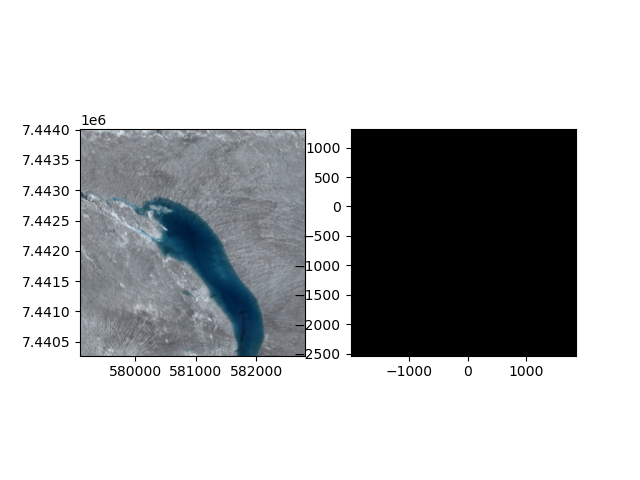

In [132]:
fig, axs = plt.subplots(ncols=2)
# Open the GeoTIFF image
ax = axs[0]
with rio.open(fnimg) as orgimg:
    data = orgimg.read([4, 3, 2])  # Assuming bands 4, 3, 2 represent RGB
    # data = reshape_as_image(data)  # Reshape the data for display
    print(orgimg.tags(0))
    
    # Normalize the data for display
    data = data - np.nanmin(data[data != 0])
    data = data / np.nanmax(data)

    # Get the original affine transform
    rioplot.show(data, ax=ax, transform=orgimg.transform)

ax = axs[1]
with rio.open(output_file) as orgimg:
    data = orgimg.read([4, 3, 2])  # Assuming bands 4, 3, 2 represent RGB
    # data = reshape_as_image(data)  # Reshape the data for display
    
    # Normalize the data for display
    # data = data - np.nanmin(data[data != 0])
    # data = data / np.nanmax(data)

    # Get the original affine transform
    rioplot.show(data, ax=ax, transform=orgimg.transform)

In [117]:
data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [59]:
import numpy as np
import rasterio as rio
from rasterio.plot import reshape_as_image
from rasterio import Affine
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import math

# Define the rotation angle and origin
fnimg = 'data/is2comp/testing/lake_greenland_melling_1_ensemble_depth_estimates.tiff'
angle_deg = 45  # Rotation angle in degrees
x_origin = gdf.x.iloc[0]
y_origin = gdf.y.iloc[0]
print('fnimg:', fnimg)
print('angle_deg:', angle_deg)
print('x_origin:', x_origin)
print('y_origin:', y_origin)

# Open the GeoTIFF image
with rio.open(fnimg) as orgimg:
    data = orgimg.read([4, 3, 2])  # Assuming bands 4, 3, 2 represent RGB
    data = reshape_as_image(data)  # Reshape the data for display
    
    # Normalize the data for display
    data = data - np.nanmin(data[data != 0])
    data = data / np.nanmax(data)

    # Get the original affine transform
    original_transform = orgimg.transform

    # Calculate the new transformation:
    # Step 1: Translate the image so that the origin is at (0, 0)
    translate_to_origin = Affine.translation(-x_origin, -y_origin)
    
    # Step 2: Apply the rotation around the origin
    rotation_rad = math.radians(angle_deg)
    rotation_transform = Affine.rotation(rotation_rad)
    
    # Step 3: Translate back from origin to (x_origin, y_origin)
    translate_back = Affine.translation(x_origin, y_origin)
    
    # Combine all transformations
    custom_transform = translate_to_origin * rotation_transform * translate_back
    
    # Apply this transformation to the original affine transform of the image
    combined_transform = original_transform * custom_transform

# Calculate the new extent based on the transformed coordinates
height, width, _ = data.shape
cols, rows = np.meshgrid(np.arange(width), np.arange(height))
coords = np.vstack([cols.flatten(), rows.flatten(), np.ones(cols.size)])
new_coords = combined_transform * coords
new_x = new_coords[0, :]
new_y = new_coords[1, :]

extent = [new_x.min(), new_x.max(), new_y.min(), new_y.max()]

# Plotting the image using matplotlib
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(data, extent=extent, origin='upper', transform=Affine2D().rotate_deg(angle_deg) + ax.transData)
ax.set_title('Rotated Image with Custom Origin')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

# Set the limits of the plot to match the extent
ax.set_xlim([new_x.min(), new_x.max()])
ax.set_ylim([new_y.min(), new_y.max()])

plt.show()


fnimg: data/is2comp/testing/lake_greenland_melling_1_ensemble_depth_estimates.tiff
angle_deg: 45
x_origin: 581004.4045757235
y_origin: 7442752.926972383


ValueError: operands could not be broadcast together with shapes (9,) (3,139128) 

fnimg: data/is2comp/testing/lake_greenland_melling_1_ensemble_depth_estimates.tiff
angle_deg: 45
x_origin: 581004.4045757235
y_origin: 7442752.926972383


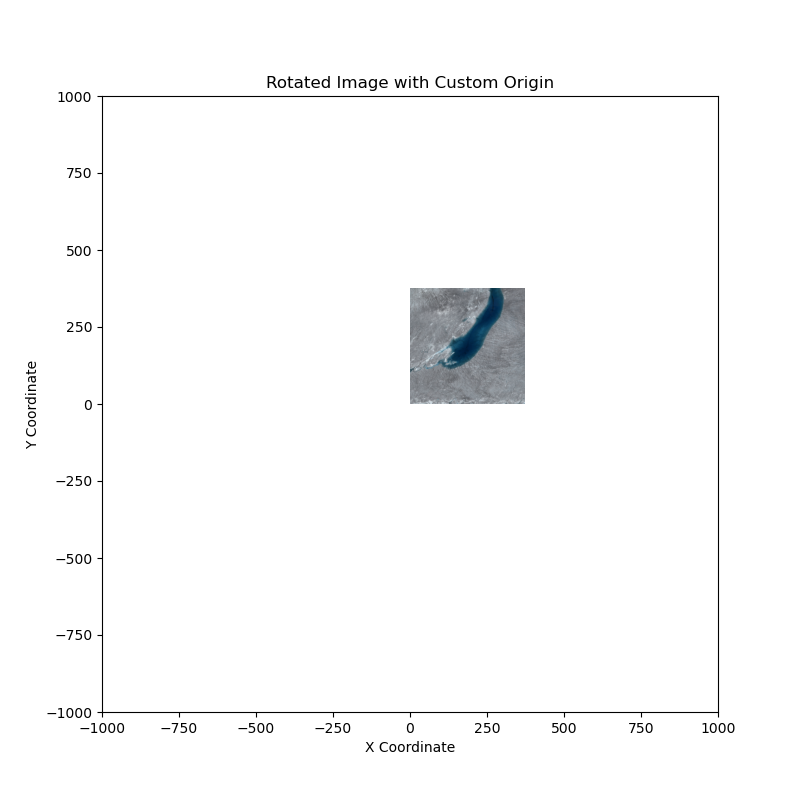

In [89]:
import numpy as np
import rasterio as rio
from rasterio.plot import reshape_as_image
from rasterio import Affine
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import math

# Define the rotation angle and origin
fnimg = 'data/is2comp/testing/lake_greenland_melling_1_ensemble_depth_estimates.tiff'
angle_deg = 45  # Rotation angle in degrees
x_origin = 581004.4045757235
y_origin = 7442752.926972383

print('fnimg:', fnimg)
print('angle_deg:', angle_deg)
print('x_origin:', x_origin)
print('y_origin:', y_origin)

# Open the GeoTIFF image
with rio.open(fnimg) as orgimg:
    data = orgimg.read([4, 3, 2])  # Assuming bands 4, 3, 2 represent RGB
    data = reshape_as_image(data)  # Reshape the data for display
    
    # Normalize the data for display
    data = data - np.nanmin(data[data != 0])
    data = data / np.nanmax(data)

    # Get the original affine transform
    original_transform = orgimg.transform

    # Calculate the new transformation:
    # Step 1: Translate the image so that the origin is at (0, 0)
    translate_to_origin = Affine.translation(-x_origin, -y_origin)
    
    # Step 2: Apply the rotation around the origin
    rotation_rad = math.radians(angle_deg)
    rotation_transform = Affine.rotation(rotation_rad)
    
    # # Step 3: Translate back from origin to (x_origin, y_origin)
    # translate_back = Affine.translation(x_origin, y_origin)
    
    # Combine all transformations
    custom_transform = translate_to_origin * rotation_transform # * translate_back
    
    # Apply this transformation to the original affine transform of the image
    combined_transform = original_transform * custom_transform
    # combined_transform = np.array(combined_transform).reshape(3,3)[:2,:]

# Calculate the new extent based on the transformed coordinates
height, width, _ = data.shape
cols, rows = np.meshgrid(np.arange(width), np.arange(height))
coords = np.vstack([cols.flatten(), rows.flatten(), np.ones(cols.size)])

# Apply the transformation using the Affine matrix components
new_coords = combined_transform * coords[:2]
new_x = new_coords[0]
new_y = new_coords[1]

extent = [new_x.min(), new_x.max(), new_y.min(), new_y.max()]

# Plotting the image using matplotlib
fig, ax = plt.subplots(figsize=(8, 8))
# ax.imshow(data, extent=extent, origin='upper', transform=Affine2D().rotate_deg(angle_deg) + ax.transData)
ax.imshow(data)
ax.set_title('Rotated Image with Custom Origin')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

# Set the limits of the plot to match the extent
# ax.set_xlim([new_x.min(), new_x.max()])
# ax.set_ylim([new_y.min(), new_y.max()])
ax.set_xlim(-1000, 1000)
ax.set_ylim(-1000, 1000)

plt.show()


In [79]:
new_coords[0]

array([-441660.39084345, -441650.39178295, -441640.39272245, ...,
       -438021.86595236, -438011.86689186, -438001.86783136])

In [76]:
fig, ax = plt.subplots(figsize=(8, 8))
with rio.open(fnimg) as orgimg:
    data = orgimg.read([4, 3, 2])  # Assuming bands 4, 3, 2 represent RGB
    data = data - np.nanmin(data[data!=0])
    data = data / np.nanmax(data)
    data = reshape_as_image(data)  # Reshape the data for display
    original_transform = orgimg.transform
    ax.imshow(data, transform=orgimg.transform)

TypeError: 'transform' must be an instance of matplotlib.transforms.Transform, not a affine.Affine

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous view', 'arrow-left', 'back'), ('Forward', 'Forward to next view', 'arrow-right', 'forward'), ('Pan', 'Left button pans, Right button zooms\nx/y fixes axis, CTRL fixes aspect', 'arrows', 'pan'), ('Zoom', 'Zoom to rectangle\nx/y fixes axis', 'square-o', 'zoom'), ('Download', 'Download plot', 'floppy-o', 'save_figure')]))

In [73]:
# Open the GeoTIFF image
with rio.open(fnimg) as orgimg:
    data = orgimg.read([4, 3, 2])  # Assuming bands 4, 3, 2 represent RGB
    data = reshape_as_image(data)  # Reshape the data for display
    
    # Normalize the data for display
    data = data - np.nanmin(data[data != 0])
    data = data / np.nanmax(data)

    # Get the original affine transform
    original_transform = orgimg.transform

    # Calculate the new transformation:
    # Step 1: Translate the image so that the origin is at (0, 0)
    translate_to_origin = Affine.translation(-x_origin, -y_origin)
    
    # Step 2: Apply the rotation around the origin
    rotation_rad = math.radians(angle_deg)
    rotation_transform = Affine.rotation(rotation_rad)
    
    # Step 3: Translate back from origin to (x_origin, y_origin)
    translate_back = Affine.translation(x_origin, y_origin)
    
    # Combine all transformations
    custom_transform = translate_to_origin * rotation_transform * translate_back
    
    # Apply this transformation to the original affine transform of the image
    combined_transform = original_transform * custom_transform

array([[  0.,   1.,   2., ..., 369., 370., 371.],
       [  0.,   0.,   0., ..., 373., 373., 373.],
       [  1.,   1.,   1., ...,   1.,   1.,   1.]])

In [20]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

scale_factor=0.5
# with rio.open(fnimg) as src:
#     # Calculate the transformation parameters for the new CRS
#     transform, width, height = calculate_default_transform(
#         src.crs, wkt_crs, src.width, src.height, *src.bounds
#     )
    
#     # Update the transform and dimensions for the new resolution
#     transform = transform * transform.scale(scale_factor, scale_factor)
#     width = int(width / scale_factor)
#     height = int(height / scale_factor)
    
#     # Create metadata for the output file
#     kwargs = src.meta.copy()
#     kwargs.update({
#         'crs': wkt_crs,
#         'transform': transform,
#         'width': width,
#         'height': height,
#         'compress': 'lzw'
#     })
    
#     # Reproject and resample the image
#     with rio.open(output_file, 'w', **kwargs) as dst:
#         for i in range(1, src.count + 1):
#             reproject(
#                 source=rio.band(src, i),
#                 destination=rio.band(dst, i),
#                 src_transform=src.transform,
#                 src_crs=src.crs,
#                 dst_transform=transform,
#                 dst_crs=wkt_crs,
#                 resampling=Resampling.bilinear
#             )

with rio.open(fnimg) as src:
    # Calculate the transformation parameters for the new CRS
    transform, width, height = calculate_default_transform(
        src.crs, wkt_crs, src.width, src.height, *src.bounds
    )
    
    # Update the transform and dimensions for the new resolution
    transform = transform * transform.scale(scale_factor, scale_factor)
    width = int(width / scale_factor)
    height = int(height / scale_factor)
    
    # Apply the rotation angle
    rotation_transform = Affine.rotation(angle_deg)
    transform = transform * rotation_transform
    
    # Create metadata for the output file
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': wkt_crs,
        'transform': transform,
        'width': width,
        'height': height,
        'compress': 'lzw'
    })
    
    # Reproject and resample the image
    with rio.open(output_file, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rio.band(src, i),
                destination=rio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=wkt_crs,
                resampling=Resampling.bilinear
            )

In [14]:
rotimg.transform

Affine(5.00159951653031, 0.0, -1988.6162732576001,
       0.0, -5.00159951653031, 1314.3272382331318)

In [16]:
rotimg.transform * rotation_transform

Affine(3.53666493491794, -3.5366649349179395, -1988.6162732576001,
       -3.5366649349179395, -3.53666493491794, 1314.3272382331318)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


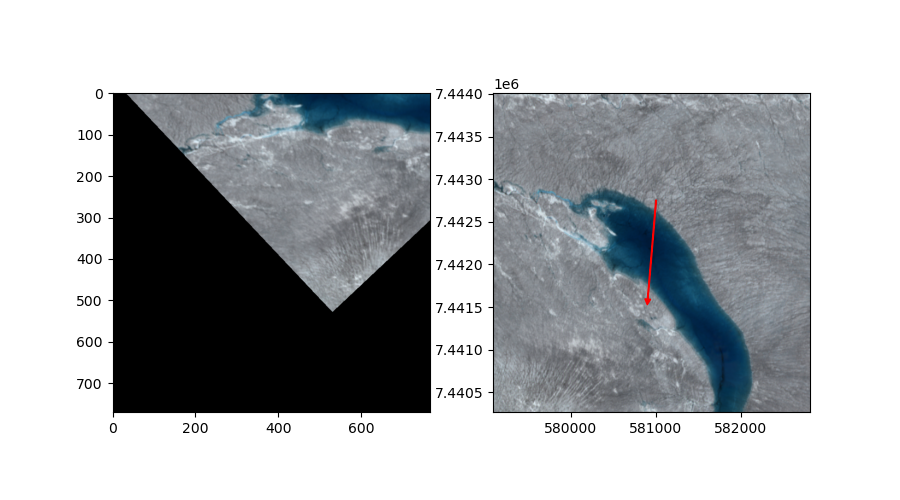

In [25]:
plt.close('all')

from rasterio import Affine

# Assuming you've already reprojected the image as before
# angle_rad = math.radians(angle_deg)
rotation_transform = Affine.rotation(angle_deg)

# # Combine with existing transform
# new_transform = transform * rotation_transform

fig, axs = plt.subplots(ncols=2, figsize=[9,5])
arrprps = dict(width=0.5, headwidth=4, headlength=4, color='r')
ax = axs[0]
with rio.open(output_file) as rotimg:
    # data = rotimg.read(1)
    data = rotimg.read([4,3,2])
    data = data - np.nanmin(data[data!=0])
    data = data / np.nanmax(data)
    # rioplot.show(data, ax=ax, transform=rotimg.transform * rotation_transform)
    # rioplot.show(data, ax=ax, transform=rotimg.transform)
    rioplot.show(data, ax=ax)
    # rioplot.show()
    # gdf_ = gdf.copy().to_crs(wkt_crs)
    # gdf_[['x', 'y']] = gdf_.geometry.get_coordinates()
    # ax.plot(gdf.dist_along_track_m, gdf.dist_along_track_m*0, 'r-')
    # ax.annotate('', xy=(gdf.dist_along_track_m.max(),0), xytext=(0,0), arrowprops=arrprps)

ax = axs[1]
with rio.open(fnimg) as orgimg:
    data = orgimg.read([4,3,2])
    data = data - np.nanmin(data[data!=0])
    data = data / np.nanmax(data)
    rioplot.show(data, ax=ax, transform=orgimg.transform)
    # ax.plot(gdf.x, gdf.y, 'r-')
    orgimg_transform = orgimg.transform
    ax.annotate('', xy=gdf[['x','y']].iloc[-1], xytext=gdf[['x','y']].iloc[0], arrowprops=arrprps)
    # ax.annotate('', xy=(gdf.x.iloc[-1], gdf.y.iloc[-1]), xytext=(gdf.x.iloc[0], gdf.y.iloc[0]))
    # thisdf = df_data[df_data.id_lake==id].copy().sort_values(by='dist_along_track_m').reset_index(drop=True)
    # gdf = gpd.GeoDataFrame(thisdf, geometry=gpd.points_from_xy(thisdf.lon, thisdf.lat), crs="EPSG:4326")
    # gdf = gdf.to_crs(img.crs)
    # gdf[['x', 'y']] = gdf.geometry.get_coordinates()

In [26]:
orgimg.transform 

Affine(10.0, 0.0, 579090.0,
       0.0, -10.0, 7444010.0)

In [29]:
rotated_transform = orgimg.transform * rotation_transform
rotated_transform

Affine(7.0710678118654755, -7.071067811865475, 579090.0,
       -7.071067811865475, -7.0710678118654755, 7444010.0)

In [30]:
gdf[['x','y']].iloc[0]

x    5.810044e+05
y    7.442753e+06
Name: 0, dtype: float64

In [27]:
rotation_transform = Affine.rotation(angle_deg)
rotation_transform

Affine(0.7071067811865476, -0.7071067811865475, 0.0,
       0.7071067811865475, 0.7071067811865476, 0.0)

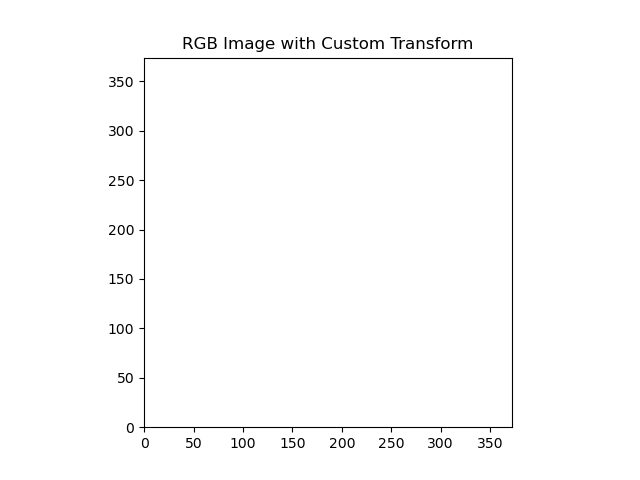

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.plot import reshape_as_image
from rasterio import Affine
from matplotlib.transforms import Affine2D

# Load the image data
with rasterio.open(fnimg) as src:
    data = src.read([4,3,2])
    data = data - np.nanmin(data[data!=0])
    data = data / np.nanmax(data)
    transform = src.transform

# Reshape the image array for display
image_rgb = reshape_as_image(data)

# Define a custom affine transform (e.g., rotate 30 degrees)
angle_deg = 30
custom_transform = Affine.rotation(angle_deg) * transform

# Define the extent of the image based on the custom transform
# This is the bounding box in data coordinates (left, right, bottom, top)
width = src.width
height = src.height
extent = (0, width, 0, height)

# Create an Affine2D object for applying the transform in Matplotlib
affine_transform = Affine2D().rotate_deg(angle_deg) + plt.gca().transData
affine_transform = Affine2D(np.array(custom_transform).reshape(3,3)) + plt.gca().transData

# Plot the image with the custom transform
fig, ax = plt.subplots()
ax.imshow(image_rgb, extent=extent, transform=affine_transform, origin='upper')
ax.set_title('RGB Image with Custom Transform')
plt.show()


In [52]:
np.array(custom_transform).reshape(3,3)

array([[ 8.66025404e+00,  5.00000000e+00, -3.22049835e+06],
       [ 5.00000000e+00, -8.66025404e+00,  6.73624677e+06],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [53]:
print(Affine2D(np.array(custom_transform).reshape(3,3)))

Affine2D(
    [[ 8.66025404e+00  5.00000000e+00 -3.22049835e+06]
     [ 5.00000000e+00 -8.66025404e+00  6.73624677e+06]
     [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]])



orgimg.transform:
| 10.00, 0.00, 579090.00|
| 0.00,-10.00, 7444010.00|
| 0.00, 0.00, 1.00|

rotated_transform:
| 7.07,-7.07, 579090.00|
|-7.07,-7.07, 7444010.00|
| 0.00, 0.00, 1.00|


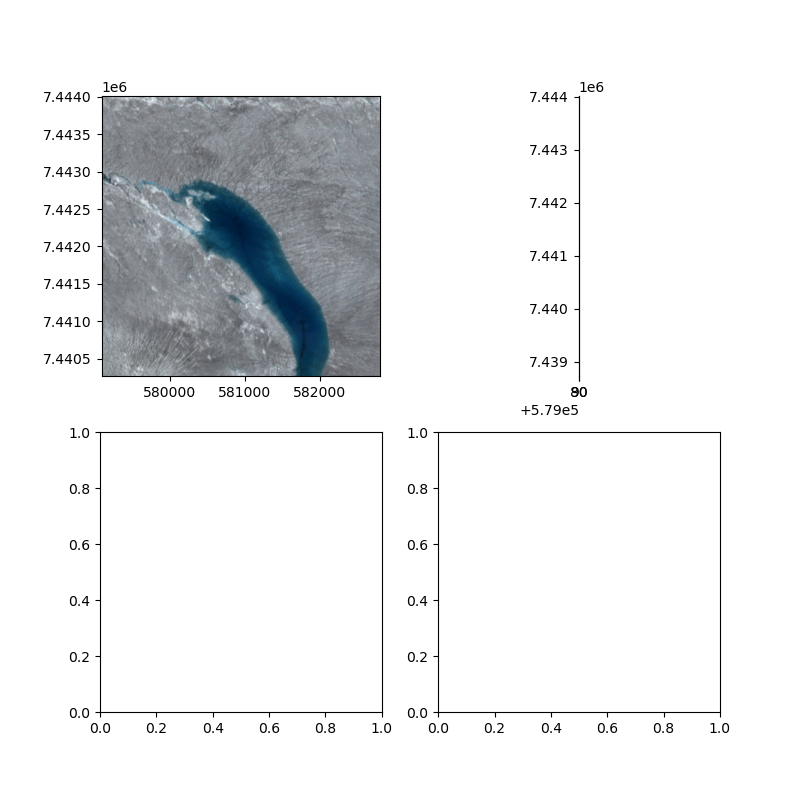

In [38]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=[8,8])
axs = axs.flatten()

angle_deg = 45
with rio.open(fnimg) as orgimg:
    data = orgimg.read([4,3,2])
    data = data - np.nanmin(data[data!=0])
    data = data / np.nanmax(data)

    ax = axs[0]
    rioplot.show(data, ax=ax, transform=orgimg.transform)
    print('\norgimg.transform:\n', orgimg.transform, sep='')

    ax = axs[1]
    rotation_transform = Affine.rotation(angle_deg)
    rotated_transform = orgimg.transform * rotation_transform
    rioplot.show(data, ax=ax, transform=rotated_transform)
    print('\nrotated_transform:\n', rotated_transform, sep='')


orgimg.transform:
| 10.00, 0.00, 579090.00|
| 0.00,-10.00, 7444010.00|
| 0.00, 0.00, 1.00|


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 9)

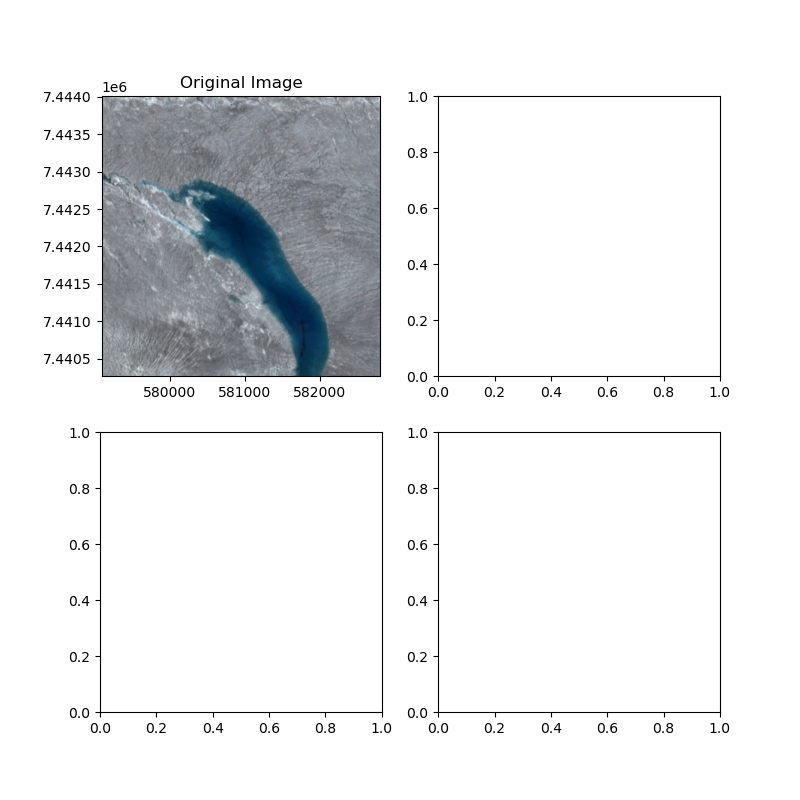

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
from rasterio import Affine
from rasterio.plot import show as rioplot


fig, axs = plt.subplots(ncols=2, nrows=2, figsize=[8,8])
axs = axs.flatten()

angle_deg = 45
with rio.open(fnimg) as orgimg:
    data = orgimg.read([4,3,2])
    data = data - np.nanmin(data[data!=0])
    data = data / np.nanmax(data)

    # Display original image
    ax = axs[0]
    rioplot(data, ax=ax, transform=orgimg.transform)
    ax.set_title('Original Image')
    print('\norgimg.transform:\n', orgimg.transform, sep='')

    # Apply rotation to the transform
    ax = axs[1]
    rotation_transform = Affine.rotation(angle_deg)
    rotated_transform = orgimg.transform * rotation_transform

    # Calculate new bounds
    width, height = data.shape[2], data.shape[1]
    x_bounds, y_bounds = np.meshgrid(np.arange(width), np.arange(height))
    x_bounds, y_bounds = x_bounds.flatten(), y_bounds.flatten()
    coords = np.vstack([x_bounds, y_bounds, np.ones_like(x_bounds)])
    new_coords = rotation_transform @ coords
    new_x_bounds, new_y_bounds = new_coords[0, :], new_coords[1, :]

    # Define extent based on the rotated coordinates
    extent = [new_x_bounds.min(), new_x_bounds.max(), new_y_bounds.min(), new_y_bounds.max()]

    # Plot rotated image with adjusted extent
    ax.imshow(np.moveaxis(data, 0, -1), extent=extent, origin='upper')
    ax.set_title('Rotated Image')
    print('\nrotated_transform:\n', rotated_transform, sep='')

plt.tight_layout()
plt.show()


In [ ]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

def reproject_geotiff(input_file, output_file, target_crs_wkt, scale_factor=0.5):
    # Open the input GeoTIFF
    with rasterio.open(input_file) as src:
        # Calculate the transformation parameters for the new CRS
        transform, width, height = calculate_default_transform(
            src.crs, target_crs_wkt, src.width, src.height, *src.bounds
        )
        
        # Update the transform and dimensions for the new resolution
        transform = transform * transform.scale(scale_factor, scale_factor)
        width = int(width / scale_factor)
        height = int(height / scale_factor)
        
        # Create metadata for the output file
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': target_crs_wkt,
            'transform': transform,
            'width': width,
            'height': height,
            'compress': 'lzw'
        })
        
        # Reproject and resample the image
        with rasterio.open(output_file, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs_wkt,
                    resampling=Resampling.bilinear
                )

# Example usage:
# reproject_geotiff('input.tif', 'output.tif', wkt_crs)


In [ ]:
['manual', 'predicted_depth', 'surrf_2024', 'RTE_Landsat8_red_pan', 'RTE_Sentinel2_red', 'Green_z_lit', 'Red_z_lit']
print(list(gdf))

In [ ]:
axset = axs[1]
ax = axset[0]


xl_img, yl_img = get_xylims_aspect(ax, img, fig)
print(xl_img, yl_img)
print((yl_img[1]-yl_img[0]) / (xl_img[1]-xl_img[0]))

In [ ]:
img.bounds

In [ ]:
include_lit_melling = True

plt.close('all')

# input data
df_melling = pd.read_csv('data/is2comp/data_melling_2024_surrfcorrected.csv',index_col=False)
df_fricker = pd.read_csv('data/is2comp/data_fricker_2021_surrfcorrected.csv',index_col=False)

conf = 0.2
df_fricker.loc[df_fricker.surrf_corr==0, 'surrf_corr'] = np.nan
df_fricker.loc[df_fricker.surrf_corr_conf<conf, 'surrf_corr'] = np.nan
df_melling.loc[df_melling.surrf_corr==0, 'surrf_corr'] = np.nan
df_melling.loc[df_melling.surrf_corr_conf<conf, 'surrf_corr'] = np.nan

# some plotting settings
plotname = 'figures/comparison_manualIS2_GrIS_AIS.jpg'
if include_lit_melling:
    plotname = plotname.replace('.jpg', '_allvalues.jpg')

plt.rcParams.update({
    'font.size': 7,
    'text.usetex': True,
    'font.family': 'Optima',
    'text.latex.preamble': r"\usepackage{amsmath}"
})

fig = plt.figure(figsize=[9,7])
gs = fig.add_gridspec(ncols=3, nrows=11)
axs = []
for i in range(9):
    axs.append(fig.add_subplot(gs[3*int(i/3):3*int(i/3)+3, i%3]))
for i in range(3):
    axs.append(fig.add_subplot(gs[9:, i]))

ref_idx = 1.336
# loop though all the lakes
for iplot, ilake in enumerate(np.hstack((np.arange(1,6), np.arange(1,5)))):
    
    ax = axs[iplot]
    source = 'melling' if iplot < 5 else 'fricker'
    source_txt = 'Fricker et al., 2021' if source=='fricker' else 'Melling et al., 2024'
    dfm = df_fricker if source=='fricker' else df_melling
    lake_file_name = 'data/is2comp/lake_amery_fricker_%i.h5' % ilake if source=='fricker' else 'data/is2comp/lake_greenland_melling_%i.h5' % ilake
    location = 'Antarctic' if source=='fricker' else 'Greenland'
    
    selector = dfm.lake_id == ilake
    dfi = dfm[selector].copy()
    lk = dictobj(read_melt_lake_h5(lake_file_name))
    hsurf = lk.surface_elevation
    df = lk.photon_data
    man_bed = hsurf - dfi.manual
    man_bed[dfi.manual == 0] = np.nan
    
    afterpulse = df.prob_afterpulse > np.random.uniform(0,1,len(df))
    xmin = dfi.dist_along_track_m[(dfi.manual>0) & ~np.isnan(dfi.manual)].min()
    xmax = dfi.dist_along_track_m[(dfi.manual>0) & ~np.isnan(dfi.manual)].max()
    xrange = xmax-xmin
    fac = 0.11
    xlim = np.array([xmin-fac*xrange, xmax+fac*xrange])
    df = df[(df.xatc > xlim[0]) & (df.xatc < xlim[1])].copy()
    df.loc[df.h < hsurf, 'h'] = hsurf - (hsurf - df.loc[df.h < hsurf, 'h']) / ref_idx
    xoff = df.xatc.min()
    df.xatc -= xoff
    dfi.dist_along_track_m -= xoff
    xlim -= xoff

    # remove zero depth values for plotting
    dfi.loc[(dfi.surrf_2024==0) | (dfi.manual==0), 'surrf_2024'] = np.nan
    dfi.loc[dfi.manual==0, 'manual'] = np.nan
    ax.scatter(df.xatc[~afterpulse], df.h[~afterpulse], s=6, color=[0.8]*3, alpha=0.35, edgecolors='none')
    p_photons = ax.scatter([-999]*4, [-999]*4, s=4, color='gray', label='ATL03 photons')
    p_manual, = ax.plot(dfi.dist_along_track_m, hsurf-dfi.manual, color='k', label='manual', lw=1, zorder=10)
    p_surrf, = ax.plot(dfi.dist_along_track_m, hsurf-dfi.surrf_2024, color='b', label='SuRRF', lw=1, zorder=11)
    p_surrf_corr, = ax.plot(dfi.dist_along_track_m, hsurf-dfi.surrf_corr, color='C1', label='SuRRF scattering\ncorrection', lw=0.7, zorder=9)

    if source == 'fricker':
        dfi.loc[dfi.RTE_Landsat8_red_pan==0, 'RTE_Landsat8_red_pan'] = np.nan
        dfi.loc[dfi.RTE_Sentinel2_red==0, 'RTE_Sentinel2_red'] = np.nan
        p_watta, = ax.plot(dfi.dist_along_track_m, hsurf-dfi.watta, color='c', ls='--', label='Watta', lw=0.7)
        p_l8, = ax.plot(dfi.dist_along_track_m, hsurf-dfi.RTE_Landsat8_red_pan, color='r', ls='--', label='RTE: Landsat 8 red/pan bands', lw=0.7)
        p_s2, = ax.plot(dfi.dist_along_track_m, hsurf-dfi.RTE_Sentinel2_red, color='r', ls=':', label='RTE: Sentinel-2 red band', lw=0.7)
        plotted_vals = dfi[['manual', 'surrf_2024', 'watta', 'RTE_Landsat8_red_pan', 'RTE_Sentinel2_red']]

    if source == 'melling':
        p_red, = ax.plot(dfi.dist_along_track_m, hsurf-dfi.Z_red, color='r', ls='--', label='RTE: Sentinel-2 red band', lw=0.7)
        p_green, = ax.plot(dfi.dist_along_track_m, hsurf-dfi.Z_green, color='g', ls='--', label='RTE: Sentinel-2 green band', lw=0.7)
        p_dem, = ax.plot(dfi.dist_along_track_m, hsurf-dfi.DEM_zeroed, color='y', ls='--', label='ArcticDEM', lw=0.7, zorder=9)
        plotted_vals = dfi[['manual', 'surrf_2024', 'Z_red', 'Z_green', 'DEM_zeroed']]
        if include_lit_melling:
            p_red_lit, = ax.plot(dfi.dist_along_track_m, hsurf-dfi.Red_z_lit, color='r', ls=':', label='RTE: Sentinel-2 red band (lit)', lw=0.6)
            p_green_lit, = ax.plot(dfi.dist_along_track_m, hsurf-dfi.Green_z_lit, color='g', ls=':', label='RTE: Sentinel-2 green band (lit)', lw=0.6)
            plotted_vals = dfi[['manual', 'surrf_2024', 'Z_red', 'Z_green', 'DEM_zeroed', 'Red_z_lit', 'Green_z_lit']]
            # ax.fill_between(dfi.dist_along_track_m, hsurf - dfi.Z_green_max_stdev_mean, hsurf - dfi.Z_green_min_stdev_mean, color='g', alpha=0.1, zorder=0)
            # ax.fill_between(dfi.dist_along_track_m, hsurf - dfi.Z_red_max_stdev_mean, hsurf - dfi.Z_red_min_stdev_mean, color='r', alpha=0.1, zorder=0)
    
    surf = np.ones_like(dfi.manual)*hsurf
    surf[(dfi.manual==0) | np.isnan(dfi.manual)] = np.nan
    p_surface, = ax.plot(dfi.dist_along_track_m, surf, 'k:', label='lake surface')
    ax.set_xlim(xlim)
    ax.set_ylim([hsurf-1.15*plotted_vals.max().max(), hsurf+0.6*plotted_vals.max().max()])
    ax.ticklabel_format(useOffset=False, style='plain')
    if iplot%3==0:
        ax.set_ylabel('elevation above geoid (m)', fontsize=10)
    if int(iplot/3) == 2:
        ax.set_xlabel('along-track distance (m)', fontsize=10)

    ax.text(0.5, 0.98, '\\textbf{%s lake %s}\n(%s)'%(location,ilake,source_txt),transform=ax.transAxes,ha='center',va='top', fontsize=9)
    ax.text(0.01, 0.99, r'\textbf{%s)}' % chr(ord('a') + iplot), transform=ax.transAxes, ha='left', va='top', fontsize=12)

# legends
empty_ = ax.scatter([],[],s=1,alpha=0,label=' ')

hdls = [[p_photons, p_surface, p_manual, p_surrf, p_surrf_corr], [p_watta, p_l8, p_s2], [p_red, p_green, p_dem]]
tits = [r'\textbf{all panels}', r'\textbf{Antarctic lakes (Fricker et al., 2021)}', r'\textbf{Greenland lakes (Melling et al., 2024)}']
for i in range(3):
    ax = axs[9+i]
    ax.axis('off')
    ncols = 2 if i==0 else 1
    if i==2 and include_lit_melling:
        pr = Line2D([],[], color='r', ls='--', lw=0.7)
        prl = Line2D([],[], color='r', ls=':', lw=0.7)
        pg = Line2D([],[], color='g', ls='--', lw=0.7)
        pgl = Line2D([],[], color='g', ls=':', lw=0.7)
        hdl_mell = [(pr, prl), (pg, pgl), p_dem]
        labels_melling = ['RTE: Sentinel-2 red (dotted: lit.)', 'RTE: Sentinel-2 green (dotted: lit.)', 'ArcticDEM']
        leg = ax.legend(handles=hdl_mell, labels=labels_melling, loc='center', fontsize=8,
                        handler_map={tuple:HandlerLinesVertical()}, handleheight=1, title=tits[i], title_fontproperties={'size': 8})
    else:
        leg = ax.legend(handles=hdls[i], ncols=ncols, loc='center', scatterpoints=4, fontsize=8, title=tits[i], title_fontproperties={'size': 8})
    leg._legend_box.align = "left"
    ax.add_artist(leg)

fig.tight_layout(pad=0.5)
for ax in axs:
    ylabs = [x for x in ax.get_yticks() if x % 1 == 0]
    ax.set_yticks(ylabs)
fig.tight_layout(pad=0.5)

# save the figure and show plot
# plt.close(fig)
# fig.savefig(plotname, dpi=600)
# display(Image(plotname))
# display(fig)

In [ ]:
# re load the files to make sure the plotting didn't meddle with the dataframes 
# (some weird stuff was happening with missing values that I had removed...)
df_melling = pd.read_csv('data/is2comp/data_melling_2024_surrfcorrected.csv',index_col=False)
df_fricker = pd.read_csv('data/is2comp/data_fricker_2021_surrfcorrected.csv',index_col=False)

print('Antarctic lakes:')
dfsel = df_fricker
stats = ['surrf_2024', 'surrf_corr', 'watta', 'RTE_Sentinel2_red', 'RTE_Landsat8_red_pan']
dfs = []
for stat in stats:
    dfs.append(getstats_comparison(dfsel, stat))
display(pd.concat(dfs))

print('Greenland lakes:')
dfsel = df_melling
stats = ['surrf_2024', 'surrf_corr', 'Z_red', 'Red_z_lit', 'Z_green', 'Green_z_lit', 'DEM_zeroed']
dfs = []
for stat in stats:
    dfs.append(getstats_comparison(dfsel, stat))
display(pd.concat(dfs))

cols = ['manual', 'surrf_2024', 'surrf_corr']
dfsel = pd.concat((df_fricker[cols], df_melling[cols]))
print('All lakes:')
display(pd.concat((getstats_comparison(dfsel, 'surrf_2024'), getstats_comparison(dfsel, 'surrf_corr'))))